[View in Colaboratory](https://colab.research.google.com/github/kbalu99/kaggle-minst-cnn/blob/master/kaggle_minst_cnn.ipynb)

In [0]:
# To import kaggle datasets
!pip install kaggle

    100% |████████████████████████████████| 61kB 3.9MB/s 
    100% |████████████████████████████████| 235kB 7.7MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
# Importing libraries
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [0]:
# import colab libraries
from google.colab import files

# import kaggle json to connect to kaggle user account to download datsets
files.upload()

In [0]:
# see if kaggle json exists
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Sep  8 02:57 kaggle.json


In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#lets now download our dataset
!kaggle competitions download -c digit-recognizer

 70% 51.0M/73.2M [00:00<00:00, 67.6MB/s]
100% 73.2M/73.2M [00:00<00:00, 158MB/s] 
 76% 37.0M/48.8M [00:00<00:00, 68.6MB/s]
100% 48.8M/48.8M [00:00<00:00, 148MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 60.2MB/s]


In [0]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [0]:
# separate out the labels 
Y_train = X_train['label']

In [0]:
X_train = X_train.drop(labels = ['label'], axis = 1)

In [0]:
# check the distribution of label values
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
X_train.isnull().any().describe()


count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
X_train = X_train /255.0
X_test = X_test / 255.0

In [0]:
# reshape the labels to fit the input format for our CNN
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

In [0]:
# label encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [0]:
# Set the random seed
random_seed = 2

In [0]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)


In [0]:
# Define CNN model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer and model checkpoint
learning_rate_reduction = [ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001),
                           ModelCheckpoint('model-cnn-minst.h5', verbose=1, save_best_only=True, save_weights_only=True)]


epochs = 25 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [0]:
# print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [0]:

# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=learning_rate_reduction)


Epoch 1/25
 - 15s - loss: 0.4124 - acc: 0.8681 - val_loss: 0.1411 - val_acc: 0.9555

Epoch 00001: val_loss improved from inf to 0.14107, saving model to model-cnn-minst.h5
Epoch 2/25
 - 14s - loss: 0.1246 - acc: 0.9639 - val_loss: 0.0369 - val_acc: 0.9883

Epoch 00002: val_loss improved from 0.14107 to 0.03691, saving model to model-cnn-minst.h5
Epoch 3/25
 - 14s - loss: 0.0953 - acc: 0.9719 - val_loss: 0.0464 - val_acc: 0.9876

Epoch 00003: val_loss did not improve from 0.03691
Epoch 4/25
 - 14s - loss: 0.0770 - acc: 0.9776 - val_loss: 0.0272 - val_acc: 0.9929

Epoch 00004: val_loss improved from 0.03691 to 0.02724, saving model to model-cnn-minst.h5
Epoch 5/25
 - 14s - loss: 0.0719 - acc: 0.9789 - val_loss: 0.0314 - val_acc: 0.9921

Epoch 00005: val_loss did not improve from 0.02724
Epoch 6/25
 - 14s - loss: 0.0678 - acc: 0.9814 - val_loss: 0.0378 - val_acc: 0.9902

Epoch 00006: val_loss did not improve from 0.02724
Epoch 7/25
 - 14s - loss: 0.0647 - acc: 0.9808 - val_loss: 0.0313 - 

In [0]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

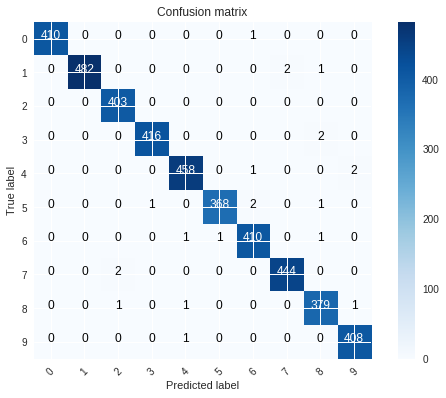

In [0]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

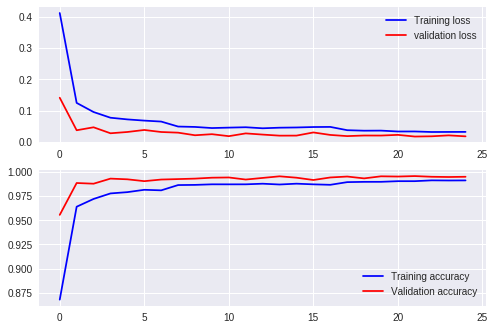

In [0]:



# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


In [0]:

# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]


In [0]:

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

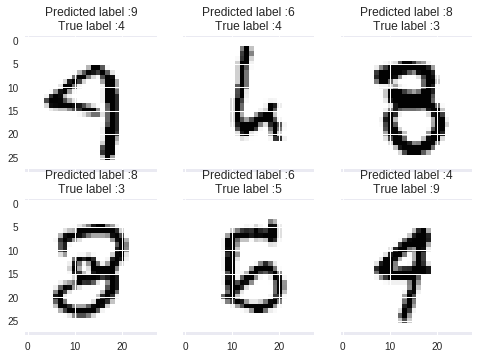

In [0]:

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


In [0]:

# predict results
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [0]:
!ls

cnn_mnist_datagen.csv  model-cnn-minst.h5  sample_submission.csv  train.csv
kaggle.json	       sample_data	   test.csv


In [0]:
# Save final model to convert and use later
model.save('new.h5')

# Now let's convert the model to JSON using tensorflowjs and use in the angular web app
!pip install tensorflowjs

    100% |████████████████████████████████| 61kB 8.2MB/s 
    100% |████████████████████████████████| 51.1MB 782kB/s 
    100% |████████████████████████████████| 12.2MB 3.6MB/s 
    100% |████████████████████████████████| 3.3MB 7.2MB/s 
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: tensorflow-hub 0.1.1
    Uninstalling tensorflow-hub-0.1.1:
      Successfully uninstalled tensorflow-hub-0.1.1
  Found existing installation: tensorboard 1.10.0
    Uninstalling tensorboard-1.10.0:
      Successfully uninstalled tensorboard-1.10.0
  Found existing installation: tensorflow 1.10.1
    Uninstalling tensorflow-1.10.1:
      Successfully uninstalled tensorflow-1.10.1


In [0]:
# Use tensorflowjs converter to convert the saved model to JSON format

!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tensorflowjs \
    new.h5 \
    model

Using TensorFlow backend.


In [0]:
# download saved h5 keras model 
files.download('new.h5')

# download converted JSON model and weights under the converted 'model' folder
files.download('/model/*.*')